In [1]:
import sys
sys.path.insert(0,"../src")
import tensorflow as tf
import keras as tfk
tfkl = tf.keras.layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import util
import GA_util
import actmax

In [2]:
latent_dim = 128
generator =tf.keras.models.load_model('../models/UTR_generator_2022-07-28')

# generator.compile()
predictor = tf.keras.models.load_model('../models/UTR_predictor')


Metal device set to: Apple M1 Ultra


2025-03-18 17:27:27.104931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-18 17:27:27.104957: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
predictor.summary()

Model: "joint_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 1, 50, 16)    1312        ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 4, 50, 1)]   0           []                               
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 1, 50, 16)   0           ['conv2d_3[0][0]']               
 out2D)                                                                                 

In [4]:
mod = actmax.ActMaxModel(generator,predictor)

In [5]:

NSEQS = 100
OUTPUT = 'UTR_high'
NSTEPS = 300
STEP_SIZE = 0.6

optimization = actmax.run_gan_opt_mult_seqs(mod,nseqs=NSEQS,output=OUTPUT,n_steps=NSTEPS,step_size=STEP_SIZE)

Start Sequence 0


2025-03-18 17:27:29.834873: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-18 17:27:29.835188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-18 17:27:30.027474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-18 17:27:30.139064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-18 17:27:30.235760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-18 17:27:30.594275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-18 17:27:30.624994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114]

Start val:  -0.37198222
Stop val:  0.9634306
iteration 0 took 10.82 seconds


Start Sequence 1
Start val:  -0.60614914
Stop val:  1.1551622
iteration 1 took 5.72 seconds


Start Sequence 2



KeyboardInterrupt



In [72]:
optimization_vecs = optimization[0]

-1.1688376353681087


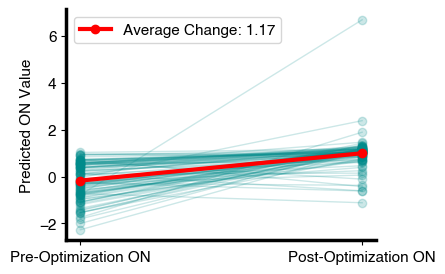

In [73]:
tick_1 = 0.25
tick_2 = 0.75

df = optimization[1]
# df = pd.read_csv('sequences/rbs_gardn_sandstorm_10_10_23.csv')

pre_mean = np.mean(df['Pre_Optimized_Value'])
post_mean = np.mean(df['Post_Optimized_Value'])
print(np.mean(df['Delta']))

plt.figure(figsize=(4,3))
plt.rcParams.update({'font.size': 11,'font.family':'Helvetica'})
plt.xticks(ticks=[tick_1,tick_2], labels=['Pre-Optimization ON','Post-Optimization ON'])
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(2.5)
plt.subplot().spines['bottom'].set_linewidth(2.5)
plt.ylabel('Predicted ON Value')
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.title('ON Value Optimization Results')
for i in range(df.shape[0]):
    plt.plot([tick_1,tick_2],[df.iloc[i,0],df.iloc[i,1]],color='darkcyan',alpha=0.2,marker='o',linewidth=1)
    
plt.plot([tick_1,tick_2],[pre_mean,post_mean],color='red',alpha=1,marker='o',linewidth=3,label='Average Change: %.2f'%(post_mean-pre_mean))
plt.legend()

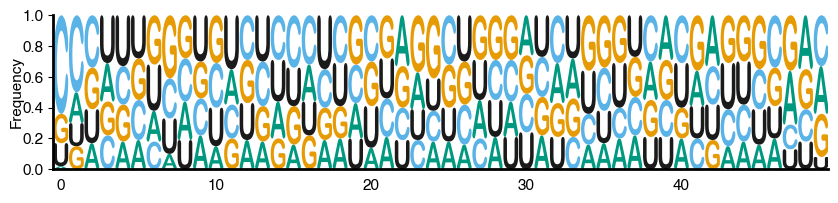

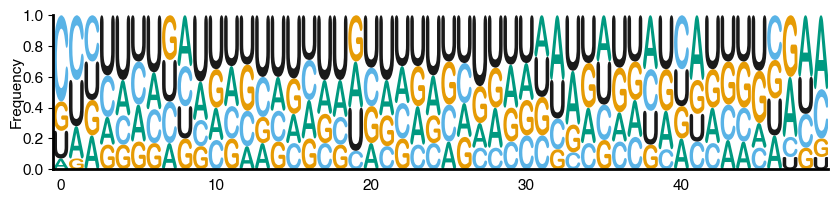

In [74]:
util.plot_logo(generator(optimization_vecs[:,:,0]))
util.plot_logo(generator(optimization_vecs[:,:,1]))

In [75]:
pre_seqs = []
post_seqs = []
for i in range(optimization_vecs.shape[0]):
    
    pre_seq = GA_util.unencode(generator(optimization_vecs[i:i+1,:,0])[0,:,:,0])
    post_seq = GA_util.unencode(generator(optimization_vecs[i:i+1,:,1])[0,:,:,0])
    
    pre_seqs.append(pre_seq)
    post_seqs.append(post_seq)
    
    
    
    

In [76]:
df['Pre_Optimized_Sequence'] = pre_seqs
df['Post_Optimized_Sequence'] = post_seqs

In [77]:
df.to_csv("../data/sequence_experiments/UTR_updated_test_high.csv")